# TODO
* Right now I use Word-level tokenization. Albert and Bert use word_piece level tokenization. Switching to that will create a lot more work with manipulation of data
* Right now I've just picked a random linear classifier without looking what kind of parameters would be best
* Right now I only use the named entities PERSON, WORK, INSTITUTION, because they are the most relevant to GDPR. But there are 13 more categories in the GT data
* Right now I use a sequence lenght of 50, haven't checked what the best one is
* Right now I only work on  20 000 sentences (640 000 words) out of 74 000 sentences, because any bigger size breaks the RAM. Need to fix a way to deal with the big dataset
* Doublecheck that all the data manipulation is done right, count amount of entities and match against confusion matrix
* Clean up code

In [1]:
import pandas as pd
import numpy as npbils
from data_functions import *
from embedding_functions import *
#https://github.com/huggingface/transformers/tree/master/model_cards/KB/albert-base-swedish-cased-alpha

Using TensorFlow backend.


## Check that GPU works

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
    
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: GeForce GTX 1050 Ti


## Load Data

In [3]:
#Load the data
df = pd.read_pickle("../data/sentence_labels")

#Work on a subset for testing purposes
input_df = df[['Sentence']].head(20000).copy()
label_df = df[['Labels']].head(20000).copy()

## Formatting the input and labels

In [4]:
data_tensor_matrix, mask_tensor_matrix = format_sentences_for_BERT(input_df)
label_matrix = format_labels_for_BERT(label_df)
label_tensor_matrix = torch.tensor(label_matrix)

Checking input...
PASS


In [5]:
from torch.utils.data import TensorDataset, random_split
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/#what-is-bert

#How much to use for training
ratio = 0.9

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(data_tensor_matrix, mask_tensor_matrix, label_tensor_matrix)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(ratio * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

18,000 training samples
2,000 validation samples


In [6]:
# Create an iterator for the dataset using the torch dataloader class.
# This saves memory during training, since we don't load the entier dataset into memory at once
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [7]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 7, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [9]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [10]:
data_tensor_matrix, mask_tensor_matrix = 0, 0

In [13]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42
epochs = 5

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


In [19]:
for step, batch in enumerate(train_dataloader):
    x = batch

In [31]:
z = x[0]
z.shape


torch.Size([16, 50])

In [16]:

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        print("Hoi")

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        print("Hoi")
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        print("Hoi")
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
Hoi
Hoi


RuntimeError: CUDA error: device-side assert triggered

## Generate Embeddings

The full embedding matrix will be on the shape 74245 x 50 x 764, taking roughtly 22GB of memory.

Unless your RAM can handle that, you'll have to break it into chunks

In [5]:
"""
Stores the embedding in a file, locally
"""
def store_embedding(data_tensor_matrix, mask_tensor_matrix, chunks):
    # Create a file to store the embedding locally
    # The shape parameter needs to match the resulting embedding for us to be able to save data to it
    embedding_array = np.memmap('EMBEDDING.mymemmap', dtype='float64', mode='w+', shape=(74245,50,768))

    #Calculate how many sentences to work at at one time
    chunksize = int(np.ceil(data_tensor_matrix.shape[0]/chunks))
    
    current_sentence = 0
    for i in trange(chunks):
        
        #Extract the data and mask chunks we will generate the embedding for
        data_tensor_chunk = data_tensor_matrix[current_sentence:current_sentence + chunksize]
        mask_tensor_chunk = mask_tensor_matrix[current_sentence:current_sentence + chunksize]
        
        #Generate the embedding
        embedding_chunk = get_embeddings_with_gpu_batch(data_tensor_chunk, mask_tensor_chunk, batch_size)
        
        #Store it in the file
        embedding_array[current_sentence:current_sentence + chunksize] = embedding_chunk
        
        #Move to the next chunk
        current_sentence += chunksize
        
#store_embedding(data_tensor_matrix, mask_tensor_matrix, 10)
#fpr = np.memmap("./EMBEDDING.mymemmap", dtype='float64', mode='r', shape=())

In [6]:
#np.save("../data/20000_embedding", embedding)
embedding = np.load('../data/20000_embedding.npy')

#embedding = get_embeddings_with_gpu_batch(data_tensor_matrix, mask_tensor_matrix, 50)

## Format Embeddings for NER

In [13]:
input_data = format_input_for_NER(embedding)

output_data, label_dict, label_list = format_output_for_NER(label_matrix)

Generated INPUT with shape (1000000, 768)
Generated LABELS with shape (1000000, 9)
Generated DICT {0: '[ P A D ]', 1: '[ U N K ]', 2: '[ C L S ]', 3: '[ S E P ]', 4: 'O', 5: 'p e r s o n', 6: 'i n s t', 7: 'e v e n t', 8: 'w o r k'}
Generated LIST of token labels


In [14]:
# Some last checks on the data
num_dimensions = input_data.shape[1]
num_classes = output_data.shape[1]

## Split into Train and Test

In [15]:
input_data

array([[ 0.10811529, -0.17934489, -0.01514136, ..., -0.24550723,
         0.09054138, -0.14829744],
       [-0.18030468, -0.13210516, -0.18551108, ..., -0.17145889,
         0.07833129, -0.13698673],
       [-0.63853472, -0.15743758, -0.14803131, ...,  0.06266064,
         0.19264977,  0.00984151],
       ...,
       [-0.80120456, -0.1020917 , -0.01053967, ..., -0.18522096,
         0.15912642,  0.06879849],
       [-0.24933141, -0.05240595, -0.00282028, ..., -0.35496697,
         0.09162017, -0.13373446],
       [-0.10775154, -0.04435734,  0.18007231, ...,  0.14403275,
         0.08055485, -0.11902191]])

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_data, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

## Train the classifier on the embeddings

In [10]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
# Define a simple baseline model
from keras.models import Sequential
from keras.layers import Dense
def baseline_model():
    # create model
    model = Sequential()
    model.add(
        Dense(8, input_dim=num_dimensions, activation='relu'))
    model.add(
        Dense(num_classes, activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',f1_m,precision_m, recall_m])
    return model

In [12]:
base_model = baseline_model()

#start from savepoint
#base_model.load_weights("../data/2020-03-31_#sentences_1000_weights.h5")
#history_df = pd.read_pickle("../data/2020-03-31_#epochs_200_history_df")


In [13]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
# Train the model, setting aside 20% data for validation
def train_model():
    history = base_model.fit(
        train_x,
        train_y,
        epochs=200,
        batch_size=50,
        validation_split=0.1)
    return history

history = train_model()
#print('\nhistory dict:', history.history.keys())

Train on 720000 samples, validate on 80000 samples
Epoch 1/200
720000/720000 [==============================] - 29s 40us/step - loss: 0.3024 - accuracy: 0.9057 - f1_m: 0.9036 - precision_m: 0.9149 - recall_m: 0.8934 - val_loss: 0.2371 - val_accuracy: 0.9265 - val_f1_m: 0.9264 - val_precision_m: 0.9341 - val_recall_m: 0.9195
Epoch 2/200
720000/720000 [==============================] - 30s 41us/step - loss: 0.2731 - accuracy: 0.9123 - f1_m: 0.9123 - precision_m: 0.9212 - recall_m: 0.9038 - val_loss: 0.2335 - val_accuracy: 0.9280 - val_f1_m: 0.9275 - val_precision_m: 0.9358 - val_recall_m: 0.9195
Epoch 3/200
720000/720000 [==============================] - 29s 40us/step - loss: 0.2686 - accuracy: 0.9135 - f1_m: 0.9135 - precision_m: 0.9225 - recall_m: 0.9049 - val_loss: 0.2338 - val_accuracy: 0.9273 - val_f1_m: 0.9271 - val_precision_m: 0.9342 - val_recall_m: 0.9205
Epoch 4/200
720000/720000 [==============================] - 30s 42us/step - loss: 0.2661 - accuracy: 0.9143 - f1_m: 0.9142 

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_history_df(history):
    training_df = pd.DataFrame()
    for metric in history.history.keys():
        training_df[metric] = history.history[metric]
    return training_df

history_df = create_history_df(history)

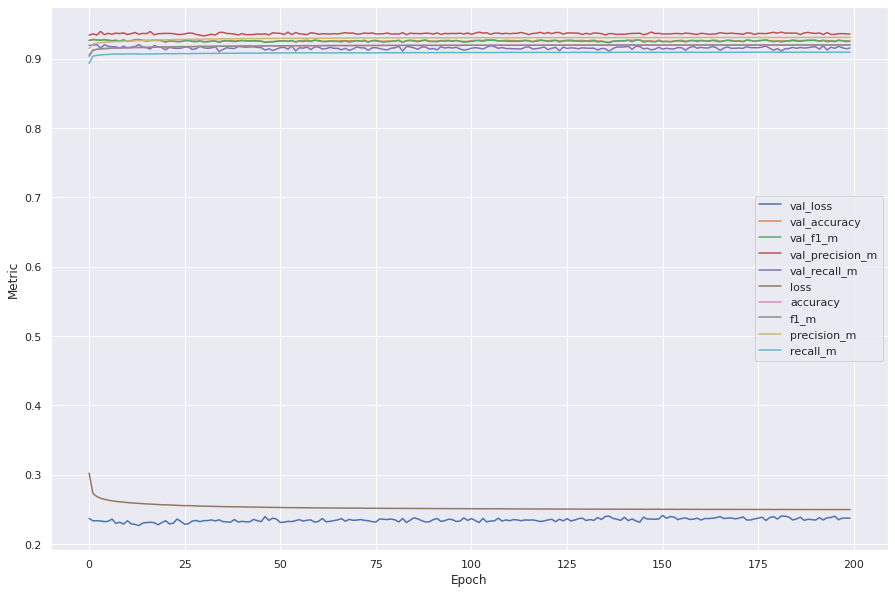

In [18]:
sns.set()
fig, ax = plt.subplots(figsize=(15,10))
history_df.plot(ax=ax)
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.show()

In [22]:
from datetime import date

#save model
WEIGHT_PATH = "../data/" + str(date.today()) + "_#sentences_" + str(train_x.shape[0]) + "_weights.h5"
base_model.save_weights(WEIGHT_PATH)

HISTORY_PATH = "../data/" + str(date.today()) + "_#epochs_"  +str(train_x.shape[0]) + "_history_df"

# Save the history object for posterity
history_df.to_pickle(HISTORY_PATH)

#Save history
print(f"Saved Model to {WEIGHT_PATH}, History to {HISTORY_PATH}")

Saved Model to ../data/2020-04-02_#sentences_800000_weights.h5, History to ../data/2020-04-02_#epochs_800000_history_df


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
#estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)

In [ ]:
from sklearn.model_selection import KFold
# Use 10 fold cross-validation to reduce risk of bias
#kfold = KFold(n_splits=2, shuffle=True)

In [ ]:
from sklearn.model_selection import cross_val_score
#results = cross_val_score(estimator, train_x, train_y, cv=kfold, verbose=1)
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# Evaluate

In [23]:

print('\n# Evaluate on test data')
results = base_model.evaluate(test_x, test_y)
for i, metric in enumerate(base_model.metrics_names):
    print(f"{metric}: {results[i]}")


# Evaluate on test data
200000/200000 [==============================] - 7s 33us/step
loss: 0.2494776782910519
accuracy: 0.9210100173950195
f1_m: 0.9201736450195312
precision_m: 0.9316348433494568
recall_m: 0.9099249839782715


In [24]:
#Get the predicted classes for the test set
predictions = base_model.predict_classes(test_x)

#Get the true classes for the test set
ground_truth = test_y.apply(lambda x: x.argmax(), axis=1).values

#confusion matrix
from sklearn.metrics import confusion_matrix
cmatrix = confusion_matrix(y_true=ground_truth, y_pred=predictions)

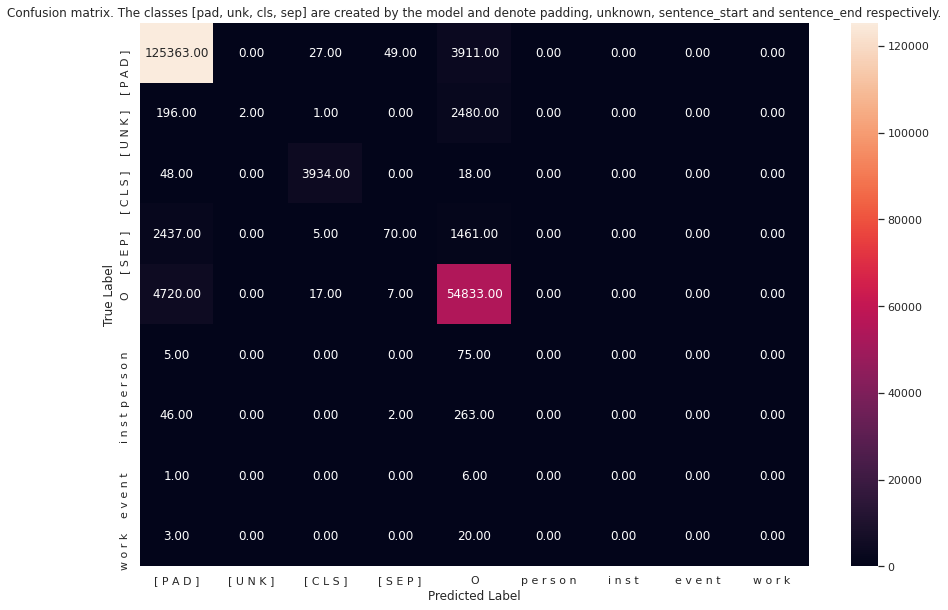

In [25]:
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(cmatrix, annot=True, ax = ax, fmt='.2f',yticklabels=list(label_dict.values()), xticklabels=list(label_dict.values()))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion matrix. The classes [pad, unk, cls, sep] are created by the model and denote padding, unknown, sentence_start and sentence_end respectively.")
plt.show()

In [68]:
cmatrix

array([[125412,      0,     79,     98,   3761,      0,      0,      0,
             0],
       [   244,      0,      5,      1,   2429,      0,      0,      0,
             0],
       [    42,      0,   3939,      0,     19,      0,      0,      0,
             0],
       [  2334,      0,      6,    101,   1532,      0,      0,      0,
             0],
       [  5026,      0,     15,     25,  54511,      0,      0,      0,
             0],
       [     8,      0,      1,      0,     71,      0,      0,      0,
             0],
       [    40,      0,      0,      1,    270,      0,      0,      0,
             0],
       [     1,      0,      0,      0,      6,      0,      0,      0,
             0],
       [     2,      0,      0,      0,     21,      0,      0,      0,
             0]])

## Test predictions

In [1]:
"""
This method takes a sentence and does NER on it

CHECK CLS/SEP tokens??
"""
def NER(sentence, classifier):
    #Format input
    tp, tm = format_sentences_for_BERT(sentence)
    
    #Split on word-level to create a dict
    tokenizer = AutoTokenizer.from_pretrained("KB/bert-base-swedish-cased-ner")
    word_list = tokenizer.tokenize(s)

    
    #Encode it 
    e = get_embeddings_with_gpu(tp, tm)
    
    #Format for NER
    n = format_input_for_NER(e)
    
    #Classify it
    c = base_model.predict(n)
    
    cols = ['word', 'entity', 'probability']

    pretty_output_df = pd.DataFrame(columns={'word', 'entity', 'probability'})
    
    #Start from 1 to skip the cls token
    #Print the predictions 
    
    predictions = c[0]

    #Take the index of the most likely word. This correspond to the class
    index = np.argmax(predictions)

    #Translate this index to a label
    #label = tokenizer.decode()

    #Grab the certainity
    certainity = predictions[index]
    
    pretty_output_df = pretty_output_df.append(pd.Series(['[CLS]', label_dict.get(index), certainity], index = cols), ignore_index=True)

    

    for i in range(len(word_list)+4):
        
        
        #Get the predictions for the first word, skip the cls token
        predictions = c[i+1]
        
        #Take the index of the most likely word. This correspond to the class
        index = np.argmax(predictions)
        
        #Translate this index to a label
        #label = tokenizer.decode()
        
        #Grab the certainity
        certainity = predictions[index]
        
        #Check which word this is
        if i <len(word_list):
            word = word_list[i]
        else:
            word = "[P A D]"
            
        pretty_output_df = pretty_output_df.append(pd.Series([word, label_dict.get(index), certainity], index = cols), ignore_index=True)   
    return pretty_output_df

s = "En enkel mening skriven av Victor från Stockholm, i förhoppningen om att KTH skall upptäckas som en institution."
x = NER(s, base_model)

NameError: name 'base_model' is not defined

In [27]:
x.to_clipboard()
x

,word,entity,probability
0,[CLS],[ C L S ],1.000000
1,En,O,0.860416
2,enkel,O,0.953946
3,mening,O,0.944405
4,skriven,O,0.807592
5,av,O,0.953121
6,Victor,O,0.925881
7,från,O,0.924545
8,Stockholm,O,0.931139
9,",",O,0.928519
